<a href="https://colab.research.google.com/github/duper203/RAG_Techniques_with_upstage/blob/main/upstage/01_Simple_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RAG (Retrieval-Augmented Generation) System


## Key Components
1. PDF processing and text extraction
2. Text chunking for manageable processing
3. Vector store creation using FAISS and Upstage embeddings
4. Retriever setup for querying the processed documents
5. Evaluation of the RAG system

## Method Details

### Document Preprocessing



*  The PDF is loaded using PyPDFLoader
*  The text is split into chunks using RecursiveCharacterTextSplitter with specified chunk size and overlap.


### Text Cleaning
A custom function `replace_t_with_space` is applied to clean the text chunks. This likely addresses specific formatting issues in the PDF.

### Vector Store Creation
* Upstage embeddings are used to create vector representations of the text chunks.
* A FAISS vector store is created from these embeddings for efficient similarity search.

### Retriever Setup
A retriever is configured to fetch the top 2 most relevant chunks for a given query.

## 0. Functions and Environment Settings

### Functions
* `replace_t_with_space` : Replaces all tab characters ('\t') with spaces
* `retrieve_context_per_question` : Retrieves relevant context and unique URLs for a given question
* `show_context` : Display the contents of the provided context list

In [68]:
def replace_t_with_space(list_of_documents):
    """
    Replaces all tab characters ('\t') with spaces in the page content of each document.

    Args:
        list_of_documents: A list of document objects, each with a 'page_content' attribute.

    Returns:
        The modified list of documents with tab characters replaced by spaces.
    """

    for doc in list_of_documents:
        doc.page_content = doc.page_content.replace('\t', ' ')  # Replace tabs with spaces
    return list_of_documents

In [69]:
def retrieve_context_per_question(question, chunks_query_retriever):
    """
    Retrieves relevant context and unique URLs for a given question using the chunks query retriever.

    Args:
        question: The question for which to retrieve context and URLs.

    Returns:
        A tuple containing:
        - A string with the concatenated content of relevant documents.
        - A list of unique URLs from the metadata of the relevant documents.
    """

    # Retrieve relevant documents for the given question
    docs = chunks_query_retriever.get_relevant_documents(question)

    # Concatenate document content
    context = [doc.page_content for doc in docs]

    return context

In [70]:
def show_context(context):
    """
    Display the contents of the provided context list.

    Args:
        context (list): A list of context items to be displayed.

    Prints each context item in the list with a heading indicating its position.
    """
    for i, c in enumerate(context):
        print(f"Context {i + 1}:")
        print(c)
        print("\n")

### Import libraries and environment variables


In [12]:
! pip3 install -qU langchain-upstage langchain-community pypdf faiss-cpu

In [71]:
from google.colab import userdata
import os
os.environ["UPSTAGE_API_KEY"] = userdata.get("UPSTAGE_API_KEY")

## Document Preprocessing

In [72]:
path = "Understanding_Climate_Change.pdf"

In [73]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_upstage import UpstageEmbeddings
from langchain.vectorstores import FAISS

def encode_pdf(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using Upstage embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = UpstageEmbeddings(model="solar-embedding-1-large")
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

In [74]:
chunks_vector_store = encode_pdf(path, chunk_size=1000, chunk_overlap=200)

## Create Retriever

In [75]:
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 2})


## Test Retriever

In [76]:
test_query = "What is the main cause of climate change?"
context = retrieve_context_per_question(test_query, chunks_query_retriever)
show_context(context)

Context 1:
driven by human activities, particularly the emission of greenhou se gases.  
Chapter 2: Causes of Climate Change  
Greenhouse Gases  
The primary cause of recent climate change is the increase in greenhouse gases in the 
atmosphere. Greenhouse gases, such as carbon dioxide (CO2), methane (CH4), and nitrous 
oxide (N2O), trap heat from the sun, creating a "greenhouse effect." This effect is  essential 
for life on Earth, as it keeps the planet warm enough to support life. However, human 
activities have intensified this natural process, leading to a warmer climate.  
Fossil Fuels  
Burning fossil fuels for energy releases large amounts of CO2. This includes coal, oil, and 
natural gas used for electricity, heating, and transportation. The industrial revolution marked 
the beginning of a significant increase in fossil fuel consumption, which continues to rise 
today.  
Coal


Context 2:
Most of these climate changes are attributed to very small variations in Earth's orbit tha

# NEED HELP IN EVAL

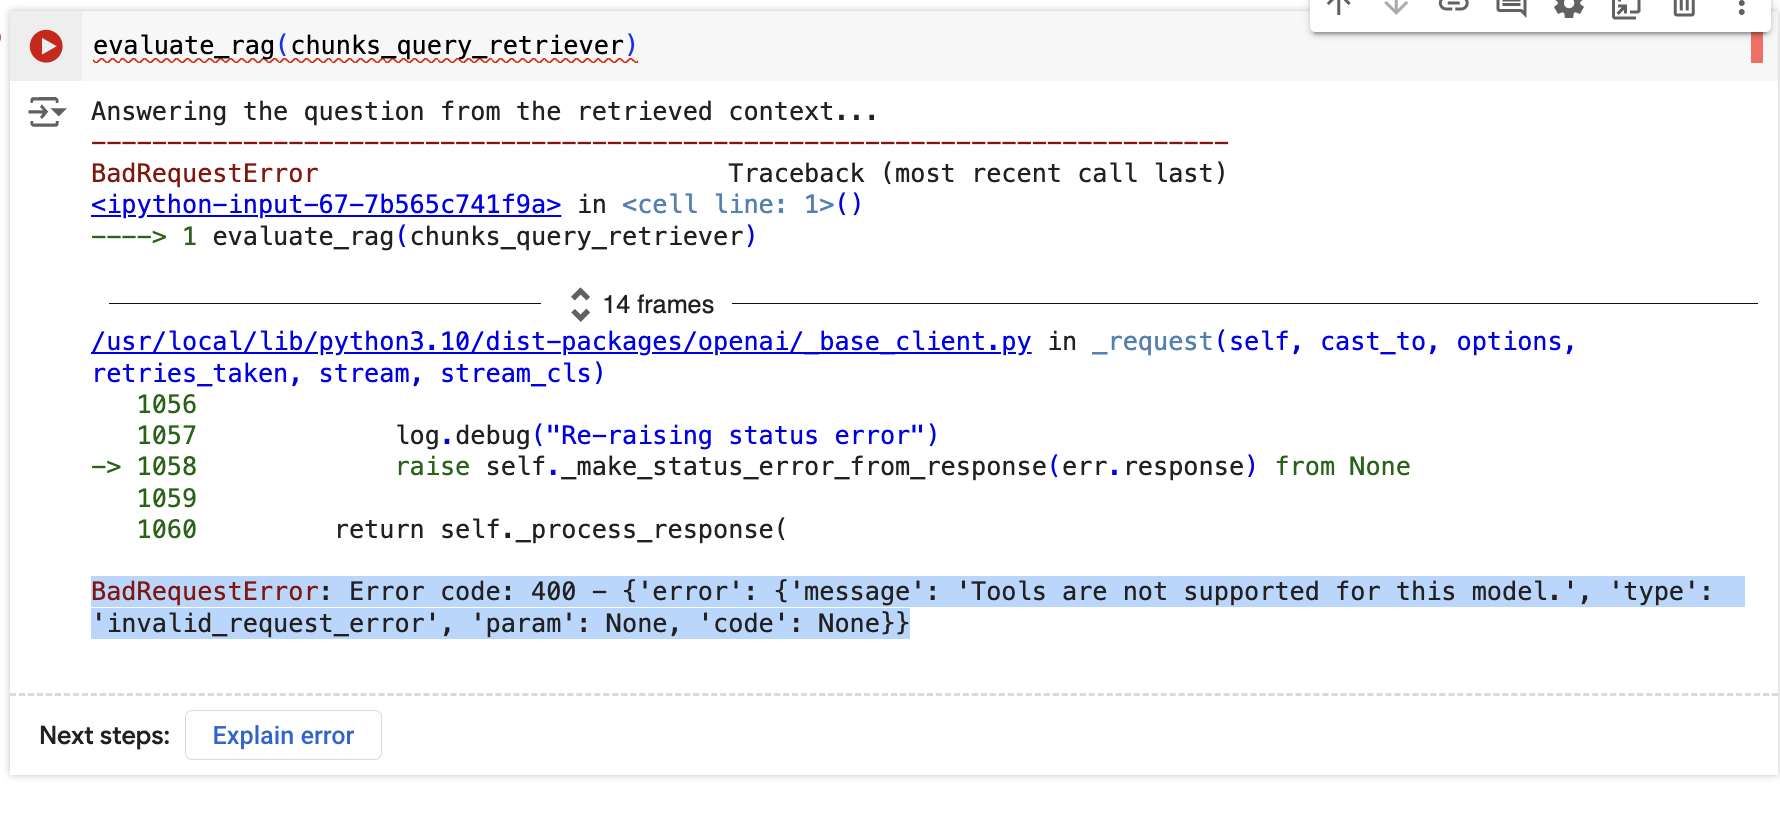

In [64]:
from langchain_upstage import ChatUpstage
import json

def evaluate_rag(chunks_query_retriever, num_questions: int = 5) -> None:
    """
    Evaluate the RAG system using predefined metrics.

    Args:
        chunks_query_retriever: Function to retrieve context chunks for a given query.
        num_questions (int): Number of questions to evaluate (default: 5).
    """
    llm = ChatUpstage(model="solar-pro")
    question_answer_from_context_chain = create_question_answer_from_context_chain(llm)

    # Load questions and answers from JSON file
    q_a_file_name = "q_a.json"
    with open(q_a_file_name, "r", encoding="utf-8") as json_file:
        q_a = json.load(json_file)

    questions = [qa["question"] for qa in q_a][:num_questions]
    ground_truth_answers = [qa["answer"] for qa in q_a][:num_questions]
    generated_answers = []
    retrieved_documents = []

    # Generate answers and retrieve documents for each question
    for question in questions:
        context = retrieve_context_per_question(question, chunks_query_retriever)
        retrieved_documents.append(context)
        context_string = " ".join(context)
        result = answer_question_from_context(question, context_string, question_answer_from_context_chain)
        generated_answers.append(result["answer"])

    # Create test cases and evaluate
    test_cases = create_deep_eval_test_cases(questions, ground_truth_answers, generated_answers, retrieved_documents)
    evaluate(
        test_cases=test_cases,
        metrics=[correctness_metric, faithfulness_metric, relevance_metric]
    )

In [61]:
from langchain.prompts import PromptTemplate
def create_question_answer_from_context_chain(llm):
    # Initialize the ChatOpenAI model with specific parameters
    question_answer_from_context_llm = llm

    # Define the prompt template for chain-of-thought reasoning
    question_answer_prompt_template = """
    For the question below, provide a concise but suffice answer based ONLY on the provided context:
    {context}
    Question
    {question}
    """

    # Create a PromptTemplate object with the specified template and input variables
    question_answer_from_context_prompt = PromptTemplate(
        template=question_answer_prompt_template,
        input_variables=["context", "question"],
    )

    # Create a chain by combining the prompt template and the language model
    question_answer_from_context_cot_chain = question_answer_from_context_prompt | question_answer_from_context_llm.with_structured_output(
        QuestionAnswerFromContext)
    return question_answer_from_context_cot_chain

In [62]:
from langchain_core.pydantic_v1 import BaseModel, Field
class QuestionAnswerFromContext(BaseModel):
    """
    Model to generate an answer to a query based on a given context.

    Attributes:
        answer_based_on_content (str): The generated answer based on the context.
    """
    answer_based_on_content: str = Field(description="Generates an answer to a query based on a given context.")


In [66]:
def answer_question_from_context(question, context, question_answer_from_context_chain):
    """
    Answer a question using the given context by invoking a chain of reasoning.

    Args:
        question: The question to be answered.
        context: The context to be used for answering the question.

    Returns:
        A dictionary containing the answer, context, and question.
    """
    input_data = {
        "question": question,
        "context": context
    }
    print("Answering the question from the retrieved context...")

    output = question_answer_from_context_chain.invoke(input_data)
    answer = output.answer_based_on_content
    return {"answer": answer, "context": context, "question": question}


In [67]:
evaluate_rag(chunks_query_retriever)

Answering the question from the retrieved context...


BadRequestError: Error code: 400 - {'error': {'message': 'Tools are not supported for this model.', 'type': 'invalid_request_error', 'param': None, 'code': None}}